In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
import pickle

In [5]:
num_features = 1000
num_classes = 2

In [6]:
projectFolderPath = "/content/drive/MyDrive/"
# This is a shortcut in my Google Drive. You can implement the same in your version as well

trainDataPath = projectFolderPath + "preprocessed_train.csv"
testDataPath = projectFolderPath + "preprocessed_test.csv"

trainDF = pd.read_csv(trainDataPath, on_bad_lines = 'skip')
trainDF.head()

,text,label,preprocessed_text
0,Do you want to hear a story? So I was at work ...,0,want hear stori work caus scientist friend ar...
1,The author does a really good job with explain...,0,author realli good job explain great detail tz...
2,I think that you guys should all become a Seag...,0,think guy becom seago cowboy adventur world ri...
3,Why should the people Of the United States vot...,0,peopl unit state vote elector vote jolt one co...
4,"Senator, I believe that voting for the Preside...",0,senat believ vote presid unit state base popu...


In [7]:
testDF = pd.read_csv(testDataPath, on_bad_lines = 'skip')
testDF.head()

,text,label,preprocessed_text
0,The Face on Mars is nothing but a natural occu...,0,face mar noth natur occurr mar thing call ba...
1,Students have a higher chance of catching a vi...,0,student higher chanc catch viru school hour v...
2,Driverless cars have good and bad things that ...,0,driverless car good bad thing would go along ...
3,Some people might think that traveling in a gr...,1,peopl might think travel group led tour guid g...
4,How many of us students want to be forced to d...,0,mani us student want forc someth probabl mani...


In [8]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=num_features)

preprocessed_text_list = list(trainDF['preprocessed_text'])
labelList = list(trainDF['label'])
npNanRows = list()
for i in range(len(preprocessed_text_list)):
  if preprocessed_text_list[i] is np.nan:
    npNanRows.append(i)

newPreProcessedText = list()
newLabels = list()

for i in range(len(preprocessed_text_list)):
  if not i in npNanRows:
    newPreProcessedText.append(preprocessed_text_list[i])
    newLabels.append(labelList[i])

trainDF = pd.DataFrame()
trainDF['preprocessed_text'] = newPreProcessedText
trainDF['label'] = newLabels

print(trainDF.head())

# Fit and transform the preprocessed text data
X_train_bow = count_vectorizer.fit_transform(trainDF['preprocessed_text'])
X_test_bow = count_vectorizer.transform(testDF['preprocessed_text'])

                                   preprocessed_text  label
0  want hear stori  work caus scientist friend ar...      0
1  author realli good job explain great detail tz...      0
2  think guy becom seago cowboy adventur world ri...      0
3  peopl unit state vote elector vote jolt one co...      0
4  senat  believ vote presid unit state base popu...      0


In [9]:
# Initialize CountVectorizer

count_vectorizer = CountVectorizer(max_features=num_features)

# Fit and transform the preprocessed text data
X_train_cv = count_vectorizer.fit_transform(trainDF['preprocessed_text'])
X_test_cv = count_vectorizer.transform(testDF['preprocessed_text'])

In [10]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=num_features)

# Fit and transform the preprocessed text data
X_train_tfidf = tfidf_vectorizer.fit_transform(trainDF['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(testDF['preprocessed_text'])

In [11]:
y_train = trainDF["label"]
y_test = testDF["label"]

In [12]:
x_tfidf_halved, x_tfidf_removed, y_tfidf_halved, y_tfidf_removed = train_test_split(X_train_tfidf, y_train, test_size=0.5, random_state=42)

In [13]:
x_cv_halved, x_cv_removed, y_cv_halved, y_cv_removed = train_test_split(X_train_cv, y_train, test_size=0.5, random_state=42)

In [14]:
def create_model():
  model = Sequential([
      Dense(128, activation='relu', input_shape=(num_features,)),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')
  ])

  return model

In [15]:
x_tfidf_train, x_tfidf_val, y_tfidf_train, y_tfidf_val = train_test_split(x_tfidf_halved, y_tfidf_halved, test_size=0.2, random_state=42)
x_tfidf_train = x_tfidf_train.toarray()
x_tfidf_val = x_tfidf_val.toarray()
y_tfidf_train = tf.keras.utils.to_categorical(y_tfidf_train, 2)
y_tfidf_val = tf.keras.utils.to_categorical(y_tfidf_val, 2)

In [16]:
# Compile the model
model_tfidf = create_model()
model_tfidf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tfidf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

In [17]:
# Train the model
history_tfidf = model_tfidf.fit(x_tfidf_train, y_tfidf_train, batch_size=128, epochs=20, validation_data=(x_tfidf_val, y_tfidf_val))

Epoch 1/20
781/781 [==============================] - 9s 7ms/step - loss: 0.1070 - accuracy: 0.9585 - val_loss: 0.0304 - val_accuracy: 0.9898
Epoch 2/20
781/781 [==============================] - 3s 4ms/step - loss: 0.0327 - accuracy: 0.9895 - val_loss: 0.0198 - val_accuracy: 0.9942
Epoch 3/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0143 - val_accuracy: 0.9959
Epoch 4/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0150 - val_accuracy: 0.9958
Epoch 5/20
781/781 [==============================] - 4s 6ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0111 - val_accuracy: 0.9973
Epoch 6/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0123 - val_accuracy: 0.9972
Epoch 7/20
781/781 [==============================] - 3s 4ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0107 - val_accuracy: 0.9973
Epoch 

In [18]:
X_test_tfidf = X_test_tfidf.toarray()
actual_classes = y_test
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [19]:
predictions_tfidf = model_tfidf.predict(X_test_tfidf)

2706/2706 [==============================] - 5s 2ms/step


In [20]:
predicted_classes_tfidf = np.argmax(predictions_tfidf, axis=1)

In [21]:
accuracy_tfidf = np.mean(actual_classes == predicted_classes_tfidf)
accuracy_tfidf

0.9893632993405477

In [22]:
loss_tfidf = history_tfidf.history['loss']
val_loss_tfidf = history_tfidf.history['val_loss']
epochs = range(1, len(loss_tfidf) + 1)

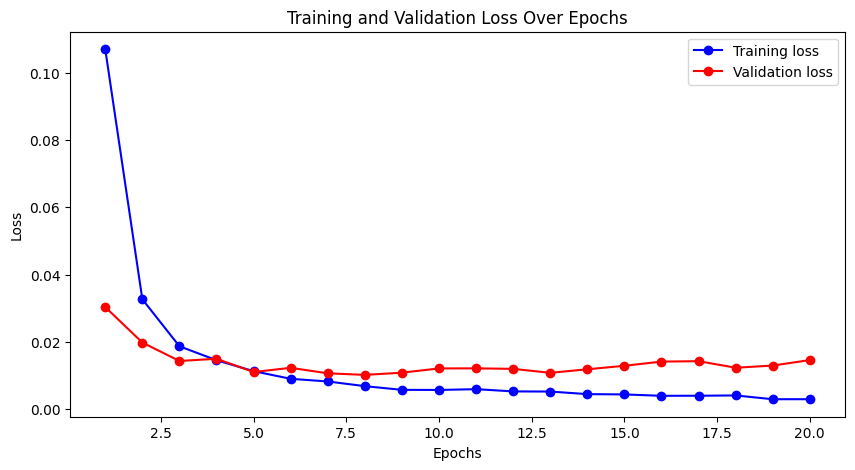

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_tfidf, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_tfidf, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
x_cv_train, x_cv_val, y_cv_train, y_cv_val = train_test_split(x_cv_halved, y_cv_halved, test_size=0.2, random_state=42)
x_cv_train = x_cv_train.toarray()
x_cv_val = x_cv_val.toarray()
y_cv_train = tf.keras.utils.to_categorical(y_cv_train, 2)
y_cv_val = tf.keras.utils.to_categorical(y_cv_val, 2)

In [25]:
# Compile the model
model_cv = create_model()
model_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               128128    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [26]:
# Train the model
history_cv = model_cv.fit(x_cv_train, y_cv_train, batch_size=128, epochs=20, validation_data=(x_cv_val, y_cv_val))

Epoch 1/20
781/781 [==============================] - 7s 7ms/step - loss: 0.1603 - accuracy: 0.9359 - val_loss: 0.0370 - val_accuracy: 0.9877
Epoch 2/20
781/781 [==============================] - 3s 4ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.0227 - val_accuracy: 0.9925
Epoch 3/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0295 - accuracy: 0.9911 - val_loss: 0.0181 - val_accuracy: 0.9950
Epoch 4/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0208 - accuracy: 0.9935 - val_loss: 0.0148 - val_accuracy: 0.9964
Epoch 5/20
781/781 [==============================] - 4s 6ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0142 - val_accuracy: 0.9965
Epoch 6/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0127 - val_accuracy: 0.9970
Epoch 7/20
781/781 [==============================] - 4s 5ms/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.0121 - val_accuracy: 0.9972
Epoch 

In [27]:
X_test_cv = X_test_cv.toarray()
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [28]:
predictions_cv = model_cv.predict(X_test_cv)
predicted_classes_cv = np.argmax(predictions_cv, axis=1)
accuracy_cv = np.mean(actual_classes == predicted_classes_cv)
accuracy_cv

2706/2706 [==============================] - 6s 2ms/step


0.990737639599478

In [29]:
loss_cv = history_cv.history['loss']
val_loss_cv = history_cv.history['val_loss']
epochs = range(1, len(loss_tfidf) + 1)

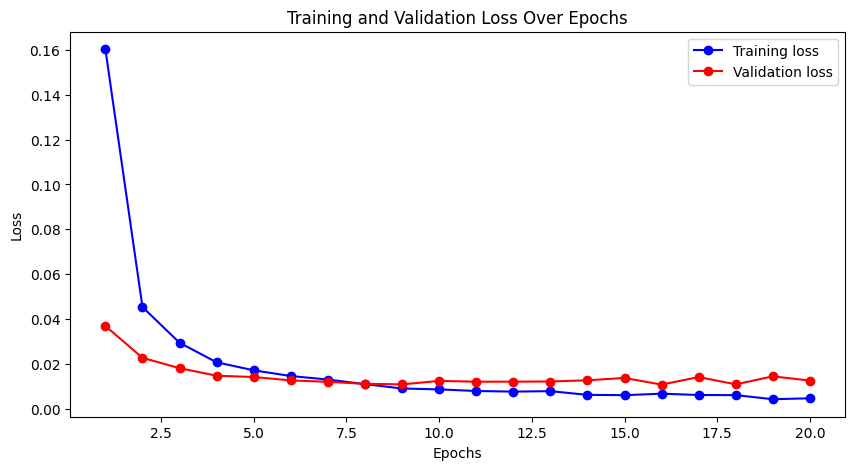

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_cv, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_cv, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
filename_cv = 'NN_CV_50train_1000features.sav'
# pickle.dump(model_, open(filename_cv, 'wb'))
pickle.dump(model_cv, open(projectFolderPath + filename_cv, 'wb'))

filename_tfidf = 'NN_TFIDF_50train_1000features.sav'
# pickle.dump(model_, open(filename_tfidf, 'wb'))
pickle.dump(model_tfidf, open(projectFolderPath + filename_tfidf, 'wb'))

In [32]:
from sklearn.metrics import classification_report

classNames = ['Human generated', 'AI-generated']

print("Classification report with tfidf-vectorizer")
print(classification_report(actual_classes, predicted_classes_tfidf, target_names = classNames))

print("Classification report with count-vectorizer")
print(classification_report(actual_classes, predicted_classes_cv, target_names = classNames))

Classification report with tfidf-vectorizer
                 precision    recall  f1-score   support

Human generated       0.99      0.99      0.99     55845
   AI-generated       0.98      0.99      0.99     30742

       accuracy                           0.99     86587
      macro avg       0.99      0.99      0.99     86587
   weighted avg       0.99      0.99      0.99     86587

Classification report with count-vectorizer
                 precision    recall  f1-score   support

Human generated       0.99      0.99      0.99     55845
   AI-generated       0.98      0.99      0.99     30742

       accuracy                           0.99     86587
      macro avg       0.99      0.99      0.99     86587
   weighted avg       0.99      0.99      0.99     86587

